In [1]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv('test.csv')

In [3]:
lb_make = LabelEncoder()
train_data["encoded_cpu_load"] = lb_make.fit_transform(train_data["cpu_load"])
train_data["encoded_m_id"] = lb_make.fit_transform(train_data["m_id"])
train_data[["cpu_load", "encoded_cpu_load","encoded_m_id"]].head(11)
train_data = train_data.drop(['cpu_load','m_id'],axis=1)
train_data

,syst_direct_ipo_rate,syst_buffered_ipo_rate,syst_page_fault_rate,syst_page_read_ipo_rate,syst_process_count,syst_other_states,page_page_write_ipo_rate,page_global_valid_fault_rate,page_free_list_size,page_modified_list_size,...,lla0_pkts_recvpsec,lla0_pkts_sentpsec,llb0_pkts_recvpsec,llb0_pkts_sentpsec,ewc0_pkts_recvpsec,ewc0_pkts_sentpsec,ewd0_pkts_recvpsec,ewd0_pkts_sentpsec,encoded_cpu_load,encoded_m_id
0,38.50,458.07,0.00,0.0,259,22,0.40,0.00,170323,60557,...,415.483,479.983,15.367,20.667,281.383,245.533,278.767,277.300,2,2
1,66.43,657.65,0.43,0.0,272,12,23.80,0.40,121776,102325,...,526.533,554.550,67.300,88.650,438.583,401.633,436.000,366.183,2,0
2,29.07,322.25,0.00,0.0,171,10,0.00,0.00,271435,44159,...,337.967,314.067,0.667,0.017,230.333,230.050,220.200,240.333,1,5
3,1063.13,286.92,4.08,0.0,253,10,0.00,0.15,171316,68325,...,336.000,379.833,24.250,33.400,249.767,251.300,178.183,139.733,0,4
4,22.97,369.32,0.00,0.0,165,10,0.00,0.00,280388,40128,...,300.833,314.983,0.733,0.017,295.583,257.300,274.200,237.250,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119777,37.37,271.95,0.00,0.0,258,22,2.38,0.00,171906,60557,...,281.467,347.533,15.667,20.967,232.067,187.883,232.000,243.217,1,2
119778,43.00,778.48,0.02,0.0,254,10,8.23,0.00,177751,66105,...,405.767,512.100,24.800,34.033,348.167,287.933,376.800,401.517,2,4
119779,34.13,790.10,0.00,0.0,218,2,6.10,0.00,191205,58975,...,600.167,804.817,20.433,27.800,439.717,581.467,475.950,561.750,2,6
119780,34.50,942.70,0.02,0.0,217,2,5.18,0.00,197985,58020,...,625.733,866.500,20.783,28.150,568.600,568.567,479.100,722.650,0,6


In [4]:
train_data_X = train_data.drop(["encoded_cpu_load"], axis=1) 
train_data_Y = train_data["encoded_cpu_load"].copy()

In [5]:
def correlation(dataset,threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (abs(corr_matrix.iloc[i,j]) >= threshold):
                col_name = corr_matrix.columns[i]
                col_corr.add(col_name)
    return col_corr

In [6]:
corr_features = correlation(train_data_X,0.91)
len(list(corr_features))

31

In [7]:
train_data_X = train_data_X.drop(corr_features,axis=1)
train_data_X

,syst_direct_ipo_rate,syst_buffered_ipo_rate,syst_page_fault_rate,syst_process_count,syst_other_states,page_page_write_ipo_rate,page_modified_list_size,io_mailbox_write_rate,io_split_transfer_rate,io_file_open_rate,...,tcp_in,tcp_retxpk,tcp_kpalv,lla0_pkts_recvpsec,lla0_pkts_sentpsec,ewc0_pkts_recvpsec,ewc0_pkts_sentpsec,ewd0_pkts_recvpsec,ewd0_pkts_sentpsec,encoded_m_id
0,38.50,458.07,0.00,259,22,0.40,60557,0.40,0.0,0.28,...,5,0,0,415.483,479.983,281.383,245.533,278.767,277.300,2
1,66.43,657.65,0.43,272,12,23.80,102325,20.58,0.0,0.73,...,4,0,0,526.533,554.550,438.583,401.633,436.000,366.183,0
2,29.07,322.25,0.00,171,10,0.00,44159,0.03,0.0,0.12,...,5,0,0,337.967,314.067,230.333,230.050,220.200,240.333,5
3,1063.13,286.92,4.08,253,10,0.00,68325,0.05,0.0,0.22,...,5,0,0,336.000,379.833,249.767,251.300,178.183,139.733,4
4,22.97,369.32,0.00,165,10,0.00,40128,0.00,0.0,0.10,...,4,0,0,300.833,314.983,295.583,257.300,274.200,237.250,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119777,37.37,271.95,0.00,258,22,2.38,60557,1.82,0.0,0.23,...,5,0,0,281.467,347.533,232.067,187.883,232.000,243.217,2
119778,43.00,778.48,0.02,254,10,8.23,66105,7.37,0.0,0.23,...,5,0,0,405.767,512.100,348.167,287.933,376.800,401.517,4
119779,34.13,790.10,0.00,218,2,6.10,58975,5.28,0.0,0.60,...,4,0,0,600.167,804.817,439.717,581.467,475.950,561.750,6
119780,34.50,942.70,0.02,217,2,5.18,58020,3.95,0.0,0.28,...,4,0,0,625.733,866.500,568.600,568.567,479.100,722.650,6


In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_data_X, train_data_Y,stratify=train_data_Y,test_size=0.2)

In [9]:
random_forest_model = RandomForestClassifier(n_jobs=-1, n_estimators=400, bootstrap=False, max_depth=25, max_features=25,random_state=1,criterion="entropy" )

In [10]:
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=25,
                       max_features=25, n_estimators=400, n_jobs=-1,
                       random_state=1)

In [11]:
y_predict_random_forest = random_forest_model.predict(X_test)

In [12]:
confusion_matrix(y_test,y_predict_random_forest)

array([[ 2325,     9,   700],
       [    5,  7998,   516],
       [  351,   496, 11557]])

In [13]:
rf_accuracy = accuracy_score(y_test,y_predict_random_forest)
print(rf_accuracy)

0.9133030012105021


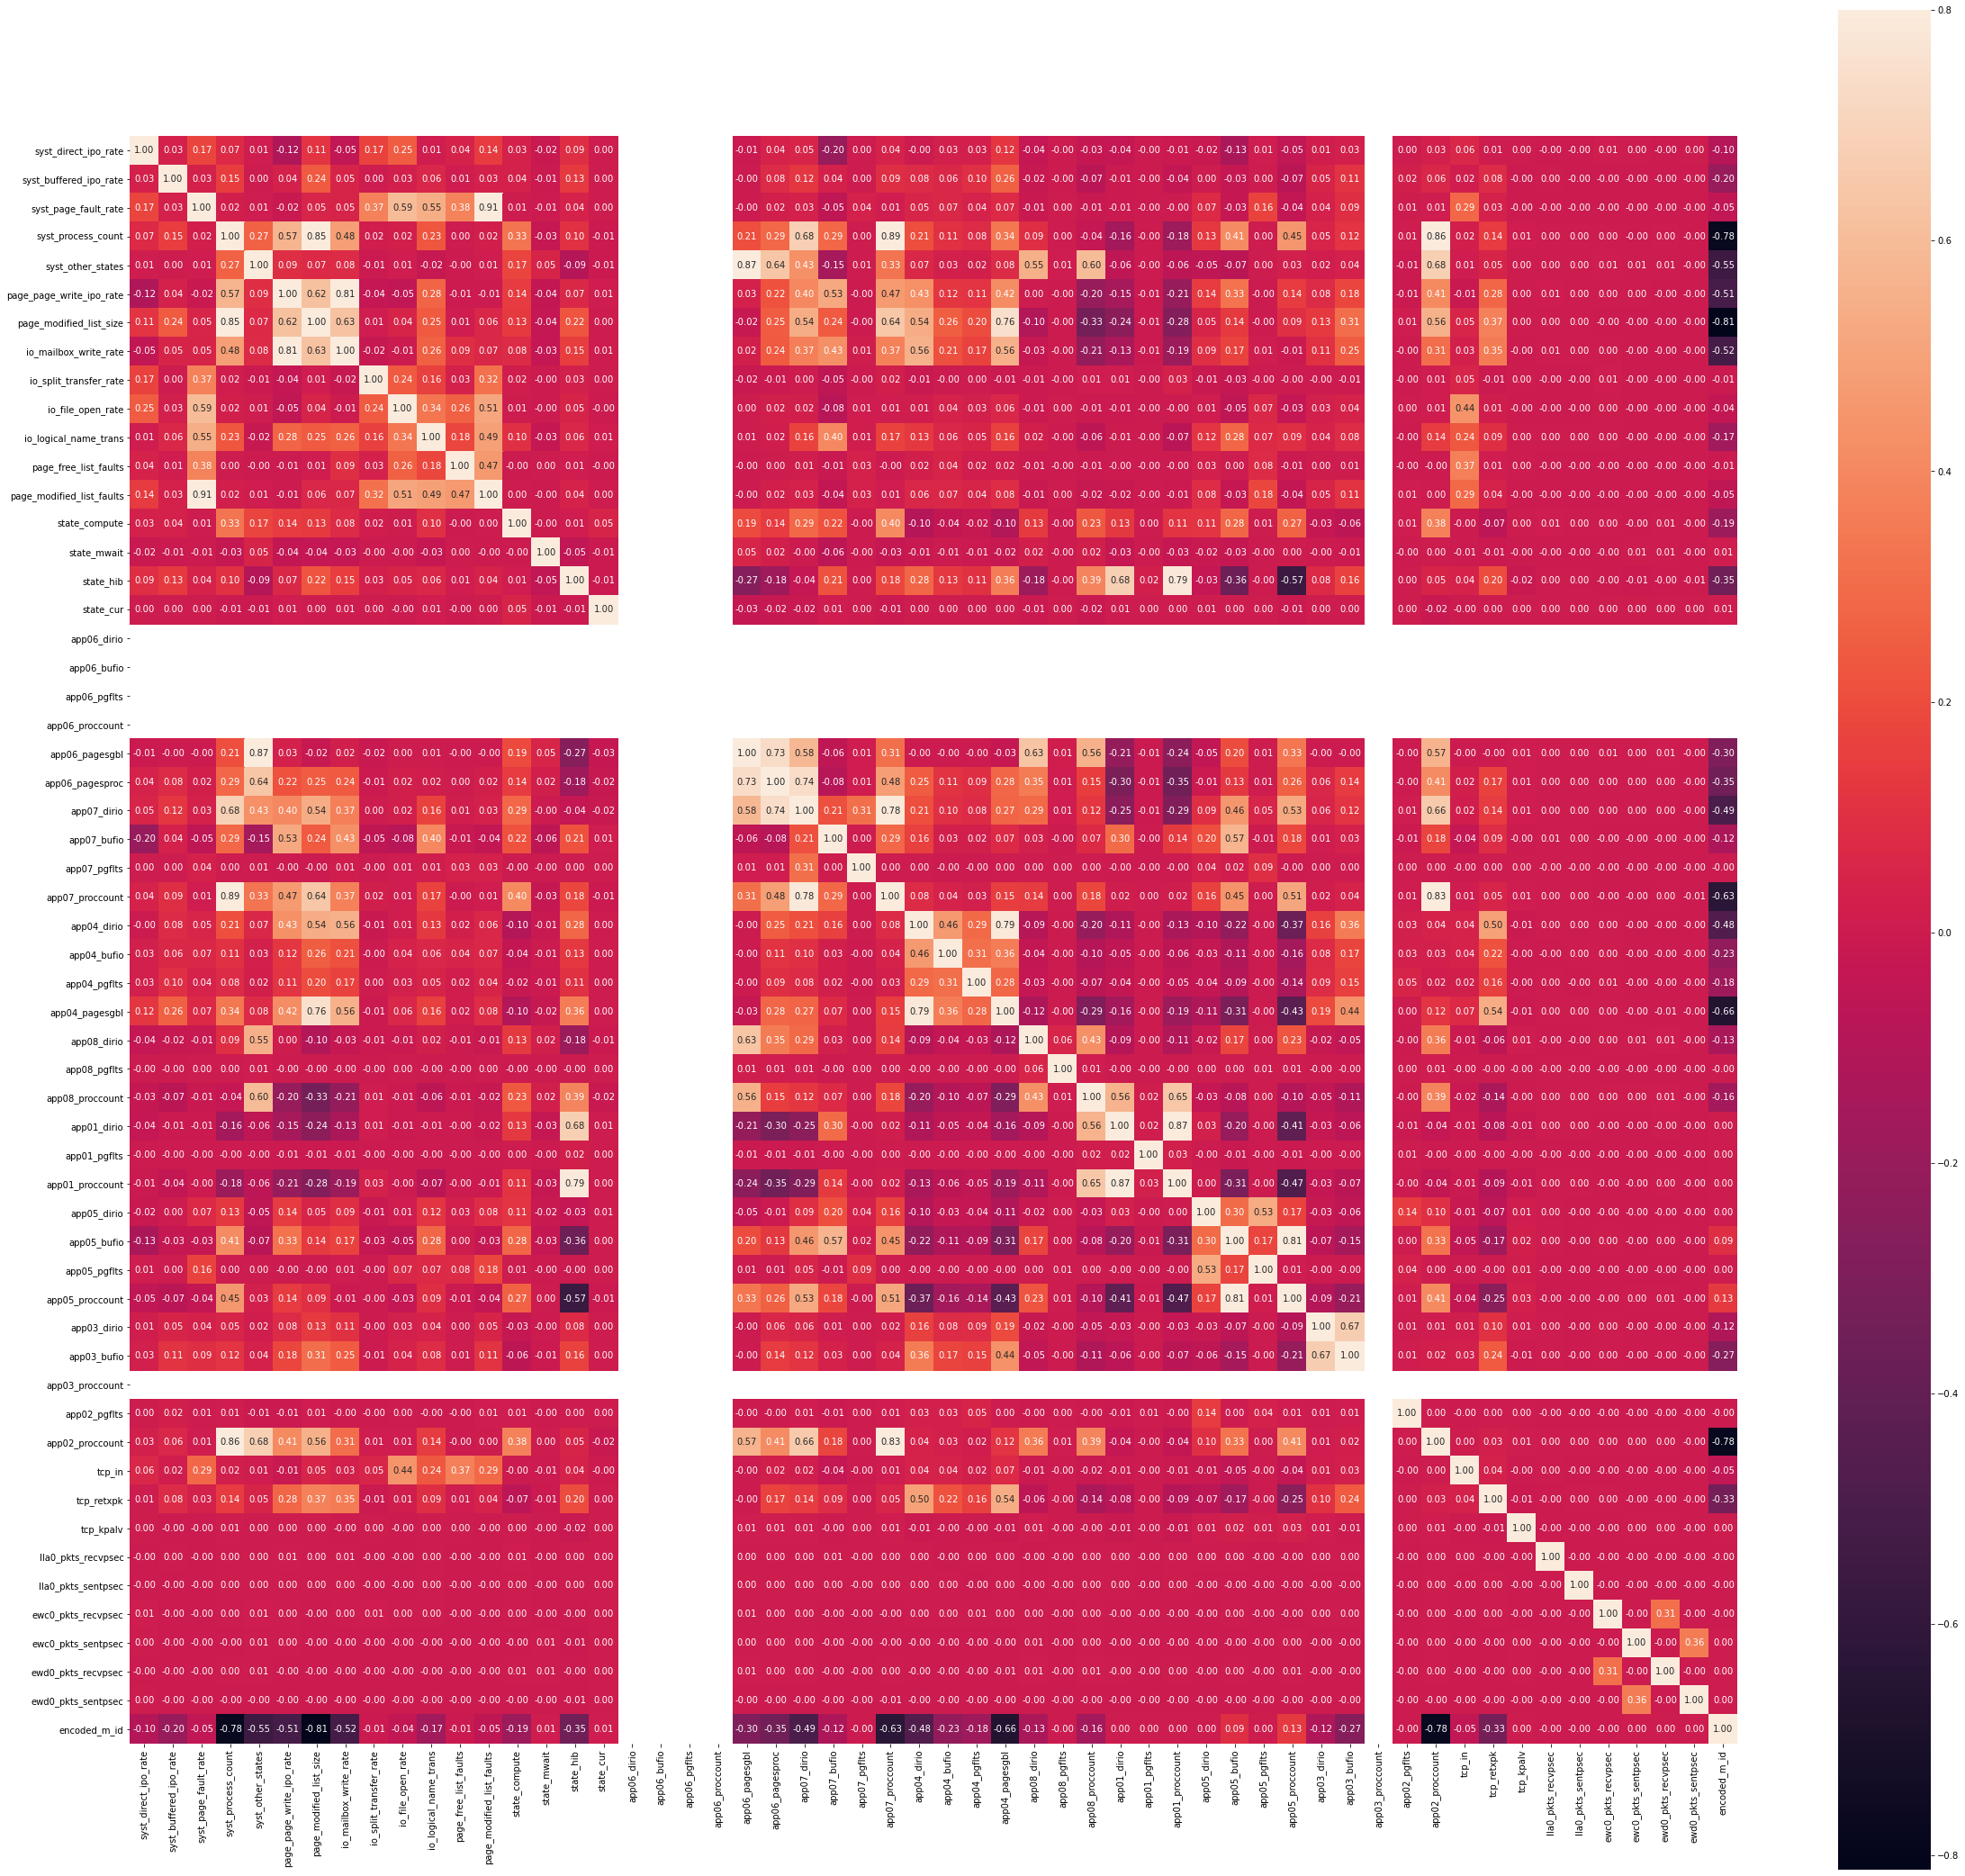

In [14]:
corrmat = X_train.corr()
f, ax = plt.subplots(figsize=(40, 38))
sns.heatmap(corrmat,annot=True, vmax=.8, fmt='.2f', square=True);

# Feature Importance

In [15]:
feature_scores = pd.Series(random_forest_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

syst_buffered_ipo_rate       0.228858
app07_bufio                  0.182220
syst_direct_ipo_rate         0.172663
io_logical_name_trans        0.095403
page_modified_list_size      0.040588
lla0_pkts_sentpsec           0.033787
app05_bufio                  0.027799
page_page_write_ipo_rate     0.020449
app05_dirio                  0.020274
lla0_pkts_recvpsec           0.014190
app08_proccount              0.013806
io_mailbox_write_rate        0.012876
ewc0_pkts_recvpsec           0.011974
syst_process_count           0.011938
ewd0_pkts_sentpsec           0.011779
ewc0_pkts_sentpsec           0.011490
ewd0_pkts_recvpsec           0.011089
io_file_open_rate            0.008824
app04_pagesgbl               0.007385
app01_dirio                  0.006858
encoded_m_id                 0.006070
app04_dirio                  0.005610
state_compute                0.005113
syst_page_fault_rate         0.005102
tcp_in                       0.003536
state_hib                    0.002986
page_modifie

In [16]:
cols_to_remove = feature_scores[feature_scores < 0.000015].index

In [17]:
len(cols_to_remove)

5

In [18]:
new_X_train = X_train.drop(cols_to_remove,axis=1)

In [19]:
new_X_test = X_test.drop(cols_to_remove,axis=1)

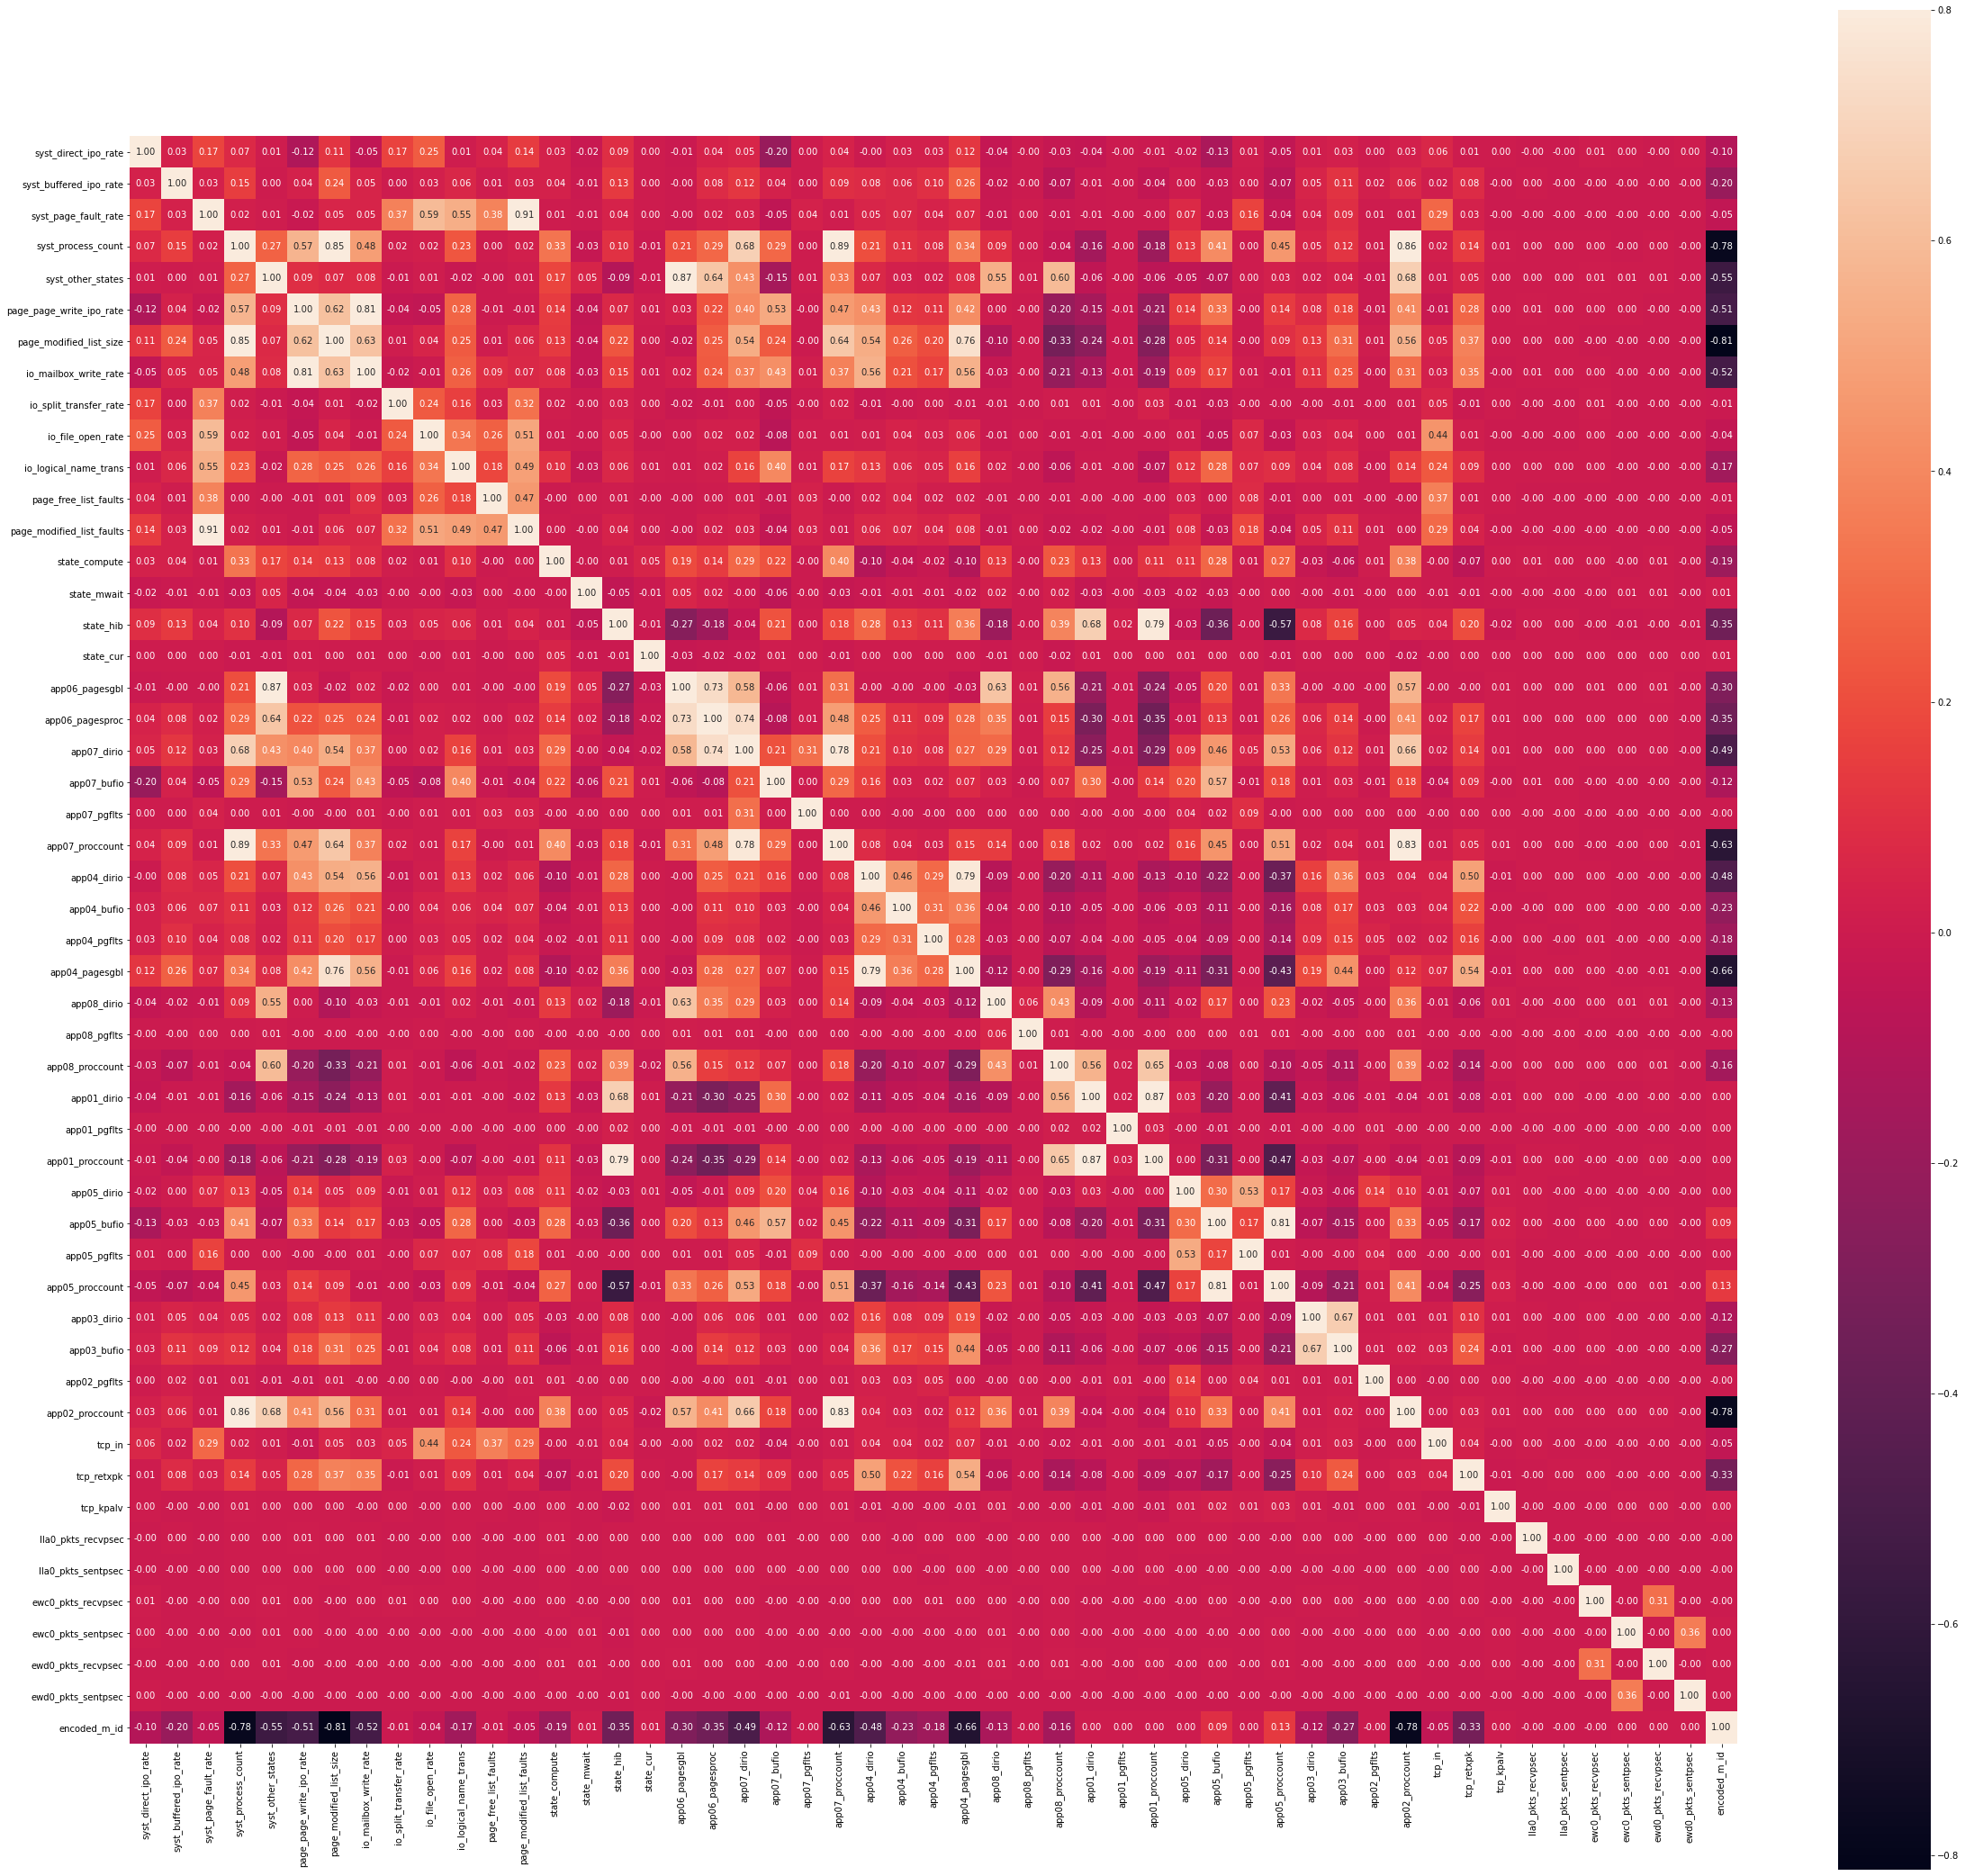

In [24]:
corrmat = new_X_train.corr()
f, ax = plt.subplots(figsize=(40, 38))
sns.heatmap(corrmat,annot=True, vmax=.8, fmt='.2f', square=True);

In [20]:
random_forest_model.fit(new_X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=25,
                       max_features=25, n_estimators=400, n_jobs=-1,
                       random_state=1)

In [21]:
y_predict_random_forest = random_forest_model.predict(new_X_test)

In [22]:
confusion_matrix(y_test,y_predict_random_forest)

array([[ 2326,     9,   699],
       [    5,  8002,   512],
       [  353,   490, 11561]])

In [23]:
rf_accuracy = accuracy_score(y_test,y_predict_random_forest)
print(rf_accuracy)

0.9136786742914388


# Hyper parameter tuning

In [25]:
param_grid = {
    'n_estimators': [100,200,300,400,500,600,1000,2000]
}

# Perform grid search on n_estimators and max_depth
gridsearch = GridSearchCV(cv=3,estimator = random_forest_model, param_grid=param_grid, verbose=10,n_jobs=-1, scoring='accuracy')
gridsearch.fit(new_X_train,y_train)

print('Best Score: ', gridsearch.best_score_)
print('Best Params: ', gridsearch.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   4 out of  24 | elapsed:  4.9min remaining: 24.5min
[Parallel(n_jobs=-1)]: Done   7 out of  24 | elapsed:  7.3min remaining: 17.7min
[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed:  9.8min remaining: 13.7min
[Parallel(n_jobs=-1)]: Done  13 out of  24 | elapsed: 14.9min remaining: 12.6min
[Parallel(n_jobs=-1)]: Done  16 out of  24 | elapsed: 18.6min remaining:  9.3min
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed: 24.9min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed: 32.2min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 32.2min finished


Best Score:  0.9101069672192974
Best Params:  {'n_estimators': 2000}


In [15]:
random_forest_model = RandomForestClassifier(n_jobs=-1, bootstrap=False, max_depth=40, max_features=30,random_state=1,criterion="entropy" )

In [16]:
param_grid = {
    'n_estimators': [1000,1200,1400]
}

# Perform grid search on n_estimators and max_depth
gridsearch = GridSearchCV(cv=3,estimator = random_forest_model, param_grid=param_grid, verbose=10,n_jobs=-1, scoring='accuracy')
gridsearch.fit(new_X_train,y_train)

print('Best Score: ', gridsearch.best_score_)
print('Best Params: ', gridsearch.best_params_)

NameError: name 'new_X_train' is not defined

# Gradient Boosting

In [33]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
    model = GradientBoostingClassifier(learning_rate=eta)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

NameError: name 'roc_curve' is not defined

In [12]:
model = GradientBoostingClassifier(max_depth=5,random_state=42,n_estimators=1000)

In [7]:
param_grid = {
    'n_estimators': [70],
    'max_features':[10,20,30]
}

# Perform grid search on n_estimators and max_depth
gridsearch = GridSearchCV(cv=3,estimator = model, param_grid=param_grid, verbose=10,n_jobs=-1, scoring='accuracy')
gridsearch.fit(X_train,y_train)

print('Best Score: ', gridsearch.best_score_)
print('Best Params: ', gridsearch.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   23.6s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   23.8s remaining:   47.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   38.1s remaining:   47.6s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   38.1s remaining:   30.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   38.7s remaining:   19.4s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   48.7s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   49.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   49.0s finished


Best Score:  0.8999843257512206
Best Params:  {'max_features': 30, 'n_estimators': 70}


In [8]:
param_grid = {
    'n_estimators': [100,150,200],
    'max_features':[30,40,50]
}

# Perform grid search on n_estimators and max_depth
gridsearch = GridSearchCV(cv=3,estimator = model, param_grid=param_grid, verbose=10,n_jobs=-1, scoring='accuracy')
gridsearch.fit(X_train,y_train)

print('Best Score: ', gridsearch.best_score_)
print('Best Params: ', gridsearch.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   7 out of  27 | elapsed:  2.5min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done  10 out of  27 | elapsed:  3.3min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done  13 out of  27 | elapsed:  4.9min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed:  5.2min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done  19 out of  27 | elapsed:  6.3min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  22 out of  27 | elapsed:  6.8min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  25 out of  27 | elapsed:  8.1min remaining:   38.9s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  8.1min finished


Best Score:  0.907299748841068
Best Params:  {'max_features': 50, 'n_estimators': 200}


In [9]:
param_grid = {
    'n_estimators': [200,300,400,500],
}

# Perform grid search on n_estimators and max_depth
gridsearch = GridSearchCV(cv=3,estimator = model, param_grid=param_grid, verbose=10,n_jobs=-1, scoring='accuracy')
gridsearch.fit(X_train,y_train)

print('Best Score: ', gridsearch.best_score_)
print('Best Params: ', gridsearch.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  9.2min remaining: 27.6min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed: 12.7min remaining: 17.7min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed: 15.0min remaining: 10.7min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 15.1min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 17.1min finished


Best Score:  0.9110670295775029
Best Params:  {'n_estimators': 500}


In [10]:
param_grid = {
    'n_estimators': [600,700,800,1000],
}

# Perform grid search on n_estimators and max_depth
gridsearch = GridSearchCV(cv=3,estimator = model, param_grid=param_grid, verbose=10,n_jobs=-1, scoring='accuracy')
gridsearch.fit(X_train,y_train)

print('Best Score: ', gridsearch.best_score_)
print('Best Params: ', gridsearch.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed: 24.8min remaining: 74.4min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed: 27.9min remaining: 39.1min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed: 30.3min remaining: 21.6min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 30.3min remaining: 10.1min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 34.3min finished


Best Score:  0.9121001710615256
Best Params:  {'n_estimators': 1000}


In [13]:
model.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=1000, random_state=42)

In [ ]:
y_predict = random_forest_model.predict(X_test)

In [ ]:
confusion_matrix(y_test,y_predict)